# Kalman filter

## 状態空間モデル
 $x_k=\mathsf{F}_kx_{k-1}+v_k$,  
 $y_k=\mathsf{H}_kx_k+w_k$.

## カルマンフィルタ
+ 予測:  
 $\boldsymbol{x}_{k|k-1}=\mathsf{F}_k\boldsymbol{x}_{k-1|k-1},\quad \mathsf{P}_{k|k-1}=\mathsf{F}_k\mathsf{P}_{k-1|k-1}\mathsf{F}_k^T+\mathsf{Q}_k$. 

+ フィルタ  
 $\boldsymbol{x}_{k|k}=\boldsymbol{x}_{k|k-1}+\mathsf{K}_k(\boldsymbol{y}_k-\mathsf{H}_k\boldsymbol{x}_k),\quad \mathsf{P}_{k|k}=(\mathsf{I}-\mathsf{K}_k\mathsf{H}_k)\mathsf{P}_{k|k-1}$,  
 $\mathsf{K}_k=\mathsf{P}_{k|k-1}\mathsf{H}_k(\mathsf{H}_k\mathsf{P}_{k|k-1}\mathsf{H}_k^T+\mathsf{R}_k)^{-1}$.

## 1次のトレンドモデル (ローカルレベルモデル) 
 $x_k=x_{k-1}+v_k$,  
 $y_k=x_k+w_k$.

## それに対するカルマンフィルタ
+ 予測:  
 $x_{k|k-1}=x_{k-1|k-1},\quad P_{k|k-1}=P_{k-1|k-1}+Q_k$.
 

+ フィルタ  
 $x_{k|k}=x_{k|k-1}+K_k(y_k-x_k),\quad P_{k|k}=(1-K_k)P_{k|k-1}$,  
 $K_k=\frac{P_{k|k-1}^2}{P_{k|k-1}+R_k}$.
 
## 2次のトレンドモデル
 $x_k=2x_{k-1}-x_{k-2}+v_k$,   
 $y_k=x_k+w_k$.
 
 書き直すと，  
 $\displaystyle \left(\begin{array}{c}
x_{k} \\
x_{k-1} \\
\end{array}\right) =\left(\begin{array}{cc}
 2 & -1 \\
 1 & 0 \\
 \end{array}\right)\left(\begin{array}{c}
x_{k-1} \\
x_{k-2} \\
\end{array}\right)+\left(\begin{array}{c}
v_{k} \\
0 \\
\end{array}\right)$,  
 $\displaystyle y_k=\left( 1 \quad 0 \right)\left(\begin{array}{c}
x_k \\
x_{k-1} \\
\end{array}\right) +w_k$.
(2次の場合，Qは2桁くらい小さくするとよい．)

## 固定ラグ平滑化
$\left(\begin{array}{c}
x_k \\
x_{k-1} \\
\vdots \\
x_{k-l} \\
\end{array}\right)=\left(\begin{array}{ccccc}
1 & 0 & \cdots & &0 \\
1 & 0 & \ddots & & \vdots \\
0 & 1 & \ddots & \ddots & \vdots \\
\vdots &  & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & 1 & 0 \\
\end{array}\right)
\left(\begin{array}{c}
x_{k-1} \\
x_{k-2} \\
\vdots \\
x_{k-l-1} \\
\end{array}\right)+\left(\begin{array}{c}
v_{k} \\
0 \\
\vdots \\
0 \\
\end{array}\right)
$,$\quad$
$y_k=(1\quad 0\quad \cdots\quad 0)\left(\begin{array}{c}
x_k \\
x_{k-1} \\
\vdots \\
x_{k-l} \\
\end{array}\right)+w_k$.


$\mathsf{F}_k=\left(\begin{array}{ccccc}
1 & 0 & \cdots & &0 \\
1 & 0 & \ddots & & \vdots \\
0 & 1 & \ddots & \ddots & \vdots \\
\vdots &  & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & 1 & 0 \\
\end{array}\right),\quad 
\mathsf{H}_k=(1\quad 0\quad \cdots\quad 0)$. 

In [19]:
import numpy as np
import matplotlib.pylab as plt

class Kalman_Filter(object):
  def __init__(self, qq, rr):
    self.q = qq*qq
    self.r = rr*rr

  def init_kalman(self, xmean_init, xstd_init ):
    self.m = 1
#    self.m = 10
    x = np.zeros((self.m))
    x[:] = xmean_init
    var = xstd_init**2 * np.eye((self.m))

    self.Fmat = np.zeros((self.m, self.m))
    self.Qmat = np.zeros((self.m,self.m))
    self.Fmat[0,0] = 1.0
    self.Qmat[0,0] = self.q
#    for i in range(self.m-1):
#      self.Fmat[i+1,i] = 1.0

    return x, var

  def prediction(self, x, var):
    x = self.Fmat.dot(x)
    var = self.Fmat.dot(var.dot(self.Fmat.T)) + self.Qmat
    return x, var

  def filtering(self, ydata, x, var):
    kalman_gain = var[:,0] / (var[0,0] + self.r )
    x = x + kalman_gain * (ydata - x[0])
    var = var - np.reshape(kalman_gain, (self.m,1)).dot(np.reshape(var[:,0], (1,self.m)))
    return x, var

In [20]:
q = 0.1
r = 1.0

data = np.loadtxt( 'Tyearly_kyoto.dat' )

td = data[:,0]
yd = data[:,1]
nt = len(yd)

Filter = Kalman_Filter(q, r)
xmean, xvar = Filter.init_kalman(10.0, 10.0 )
lag = Filter.m - 1

xmeanarr = np.zeros((nt))
xstdarr = np.zeros((nt))

for k in range(0,nt):
  xmean, xvar = Filter.prediction(xmean, xvar)

#  if k < 100:
  xmean, xvar = Filter.filtering( yd[k], xmean, xvar )

  xmeanarr[k] = xmean[0]
  xstdarr[k] = np.sqrt(xvar[0,0])
#  if k >= lag:
#    xmeanarr[k-lag] = xmean[lag]
#    xstdarr[k-lag] = np.sqrt(xvar[lag,lag])
    
#for k in range(lag):
#  xmeanarr[nt-k-1] = xmean[k]
#  xstdarr[nt-k-1] = np.sqrt(xvar[k,k])

xlarr = xmeanarr - xstdarr
xuarr = xmeanarr + xstdarr

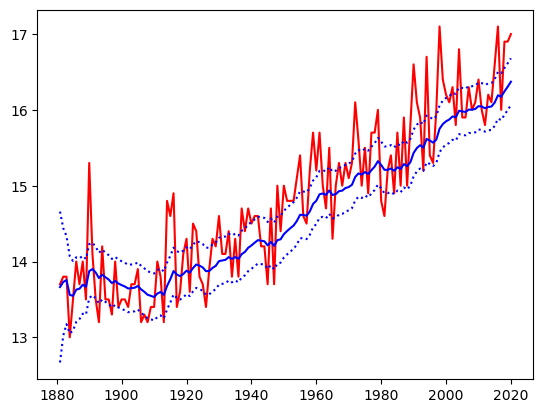

In [21]:
plt.plot( td, yd, color='red' )
plt.plot( td, xmeanarr, color='blue' )
plt.plot( td, xuarr, color='blue', linestyle='dotted' )
plt.plot( td, xlarr, color='blue', linestyle='dotted' )
plt.show()